# Model Comparisson
- Compare model performance when choosing RF's most significant features, vs. Disjointification's
- Test model performances when keeping more features

# defs / imports

In [1]:
import pandas as pd
from utils.utils import point_bi_serial_r_correlation
from utils import randomforest
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import disjointification
from copy import deepcopy
plt.style.use(['science', 'notebook'])

## Load models

In [18]:
save_point = Path(r"C:\model\09_13_2023__01_12_39\09_13_2023__01_12_39.pkl") # savepoint with full dataset and correlation threshold 0.4
disjointification_model = disjointification.from_file(save_point)
rf_model_pkl_path = Path("rf_model/rf_08_29_2023__20_41_33.pkl" )
rf_cls_model_pkl_path = Path("rf_cls_model/rf_cls_08_29_2023__21_28_52.pkl")
rf_model = randomforest.from_file(rf_model_pkl_path)
rf_cls_model = randomforest.from_file(rf_cls_model_pkl_path)
# disjointification.validation_visualize_01(save_point)

## Random Forest Feature Importance

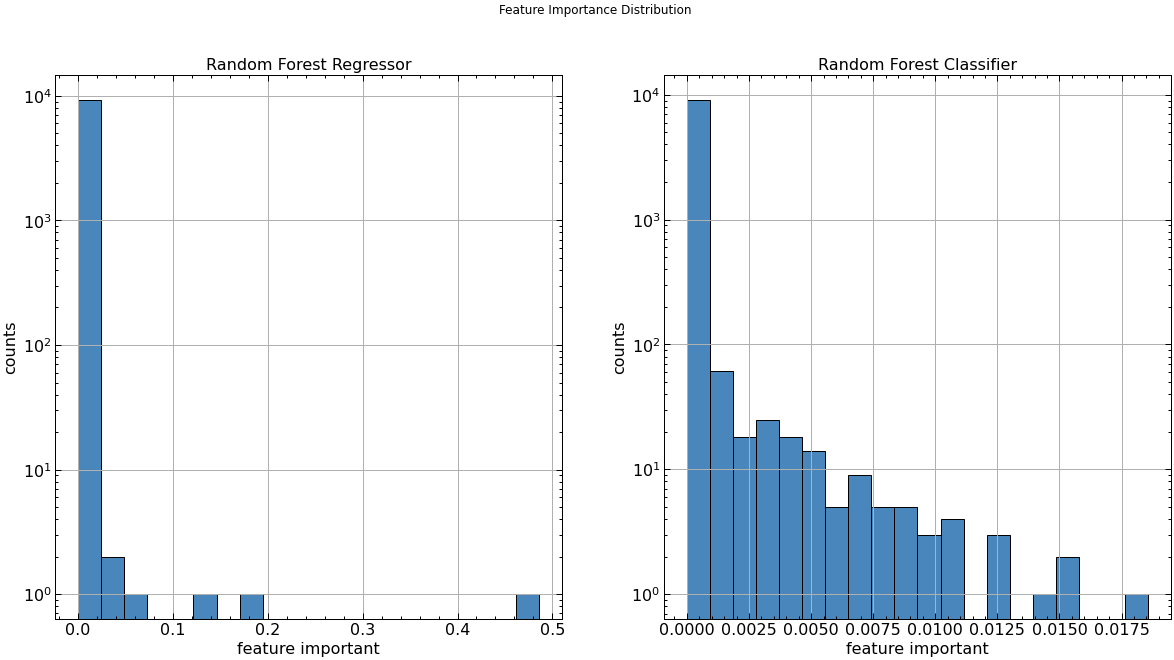

In [19]:
randomforest.show_feature_importance(rf_model, rf_cls_model)

## Compare scores using the best N features of Disjointification vs. RF

In [20]:
start_num_features, stop_num_features, num_sweep = 3,500,60

sorted_features_list_rf = [x[1] for x in sorted(zip(rf_model.rf.feature_importances_, rf_model.rf.feature_names_in_), reverse=True)]
sorted_features_list_rf_cls = [x[1] for x in sorted(zip(rf_cls_model.rf_cls.feature_importances_, rf_cls_model.rf_cls.feature_names_in_), reverse=True)]

sorted_features_list_disj_cls = disjointification_model.features_selected_in_disjointification_log
sorted_features_list_disj_reg = disjointification_model.features_selected_in_disjointification_lin

disjointification_model.init_scores_df()
disjointification_model.sweep_regression_scores(mode='lin', start_num_features=start_num_features,
                             stop_num_features=stop_num_features,
                             num_sweep=num_sweep, all_features_list=sorted_features_list_disj_reg)
disjointification_model.sweep_regression_scores(mode='log', start_num_features=start_num_features,
                             stop_num_features=stop_num_features,
                             num_sweep=num_sweep,all_features_list=sorted_features_list_disj_cls)

scores_disjointification = disjointification_model.scores_df.copy()

rf_scorer_model = deepcopy( disjointification_model)
rf_scorer_model.init_scores_df()
rf_scorer_model.features_selected_in_disjointification_lin=None
rf_scorer_model.features_selected_in_disjointification_log=None
rf_scorer_model.sweep_regression_scores(mode='lin', start_num_features=start_num_features,
                             stop_num_features=stop_num_features,
                             num_sweep=num_sweep, all_features_list=sorted_features_list_rf)
rf_scorer_model.sweep_regression_scores(mode='log', start_num_features=start_num_features,
                             stop_num_features=stop_num_features,
                             num_sweep=num_sweep,all_features_list=sorted_features_list_rf_cls)

scores_rf = rf_scorer_model.scores_df.copy()

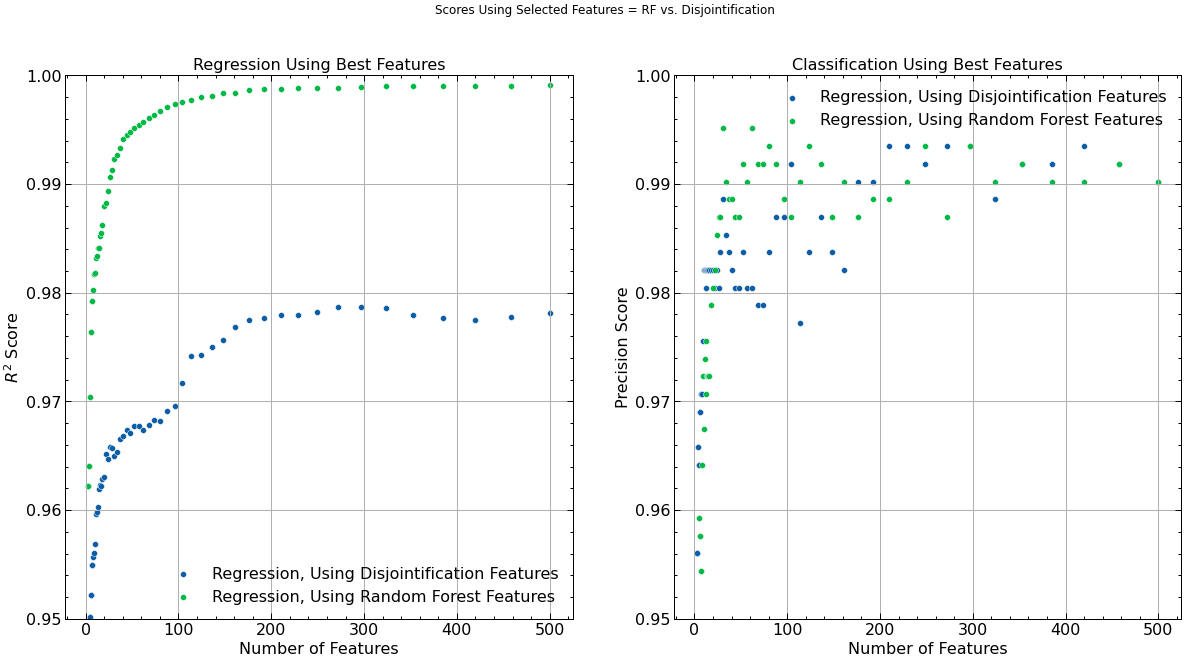

In [21]:
figsize = 20,10
fig, axs = plt.subplots(1,2,figsize=figsize)

fig.suptitle("Scores Using Selected Features = RF vs. Disjointification")
ax = axs.flatten()[0]
sns.scatterplot(data=scores_disjointification, y="scores_from_best_lin", x="num_features", ax=ax, label="Regression, Using Disjointification Features")
sns.scatterplot(data=scores_rf, y="scores_from_best_lin", x="num_features", ax=ax, label="Regression, Using Random Forest Features")
ax.set(title="Regression Using Best Features", xlabel="Number of Features", ylabel=r"$R^2$ Score")

ax = axs.flatten()[1]
sns.scatterplot(data=scores_disjointification, y="scores_from_best_log", x="num_features", ax=ax, label="Regression, Using Disjointification Features")
sns.scatterplot(data=scores_rf, y="scores_from_best_log", x="num_features", ax=ax, label="Regression, Using Random Forest Features")
ax.set(title="Classification Using Best Features", xlabel="Number of Features", ylabel=r"Precision Score")

for ax in axs.flatten():
    ax.grid('minor')
    ax.legend()
    ax.set(ylim=[0.95, 1.00])
    
plt.show()